# cbcMTSI - Collisional Beam-Core Modified Two-Stream Instability - Davies method
Or CBCLH instability: Collisional Beam-Core Lower Hybrid Instability
Solve in ordinary precision arithmetic.  Allow complex $\omega$.

Here, use the Davies method with squircle contour to find roots of $D(\omega)$ for given parameters and wavevector $\mathbf{k}$.

In [1]:
import Parameters
import PyPlot as plt
import QuadGK   # Note.  QuadGK seems to work with BigFloat, but NOT ArbComplex
import Roots    # for find_zero.  Parts of it work with univariate complex functions
                #  Note.  Looks like Roots works with BigFloat, but NOT ArbComplex
using Printf

using FromFile
@from "tools.jl" import tools
@from "dispersion_tools_mtsi.jl" import dispersion_tools_mtsi

pd = dispersion_tools_mtsi


Main.C:\Users\jacot\Documents\Plasma Physics\Other\Jupyter Notebooks\Julia notebooks\dispersion_tools_mtsi.jl.dispersion_tools_mtsi

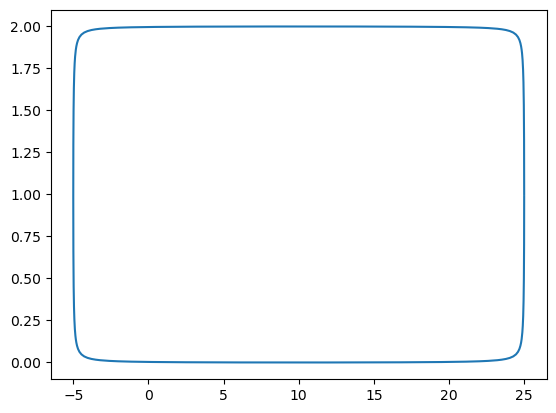

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001C573A0>

In [238]:
# squircle parameters
#a = 0.996  # squareness
a = 0.996  # squareness
Rx = 10   # center of recturcle in x  (omega_r)
rx = 15    # half-length of recturcle in x (omega_r)
Ry = 1.0  # with small epsilon, max of squircle in y goes to 2*Ry (omega_i)
epsilon = 1e-5    # bottom of squircle in omega_i

# Ry = 0.15  # with small epsilon, max of squircle in y goes to 2*Ry (omega_i)
# epsilon = 1e-4    # bottom of squircle in omega_i

smallnum = 1e-4   # small number in how squircle is parameterized
params = tools.Sqparams(a, Rx, Ry, rx, epsilon, smallnum);

visualize = true
if visualize
    N = 500
    theta = tools.theta_circle(N)
    points_on_squircle = zeros(ComplexF64, N)
    for j = 1:N
        points_on_squircle[j] = tools.gamma(theta[j], params)
    end
    z = points_on_squircle;
    plt.plot(real(z), imag(z)) 
end

In [267]:
#nu = 1e2    # nu_ei / omega_LHb
nu = 100
mu = 1836
eta = 100
tau_e = 1
tau_b = 2   # T_beam / T_core
u = 15
sigma = 1e-2

khat = 1
kxhat = khat
function D(omegahat)
    D, Dprime = dispersion_tools_mtsi.D_coll_bcMTSI(omegahat, kxhat, nu, mu, eta, tau_e, tau_b, u, sigma)
    return D
end
function Dprime(omegahat)
    D, Dprime = dispersion_tools_mtsi.D_coll_bcMTSI(omegahat, kxhat, nu, mu, eta, tau_e, tau_b, u, sigma)
    return Dprime
end
function DDprime(omegahat)
    D, Dprime = dispersion_tools_mtsi.D_coll_bcMTSI(omegahat, kxhat, nu, mu, eta, tau_e, tau_b, u, sigma)
    return D, Dprime
end

DDprime (generic function with 1 method)

In [268]:
Npts = 20000
num_zeros = tools.count_zeros_inside_sq_contour(D, Npts, params)
println("Number of zeros found: ", num_zeros)
if num_zeros != 0
    roots = tools.all_roots(DDprime, num_zeros, Npts, params)
end

Number of zeros found: 1


1-element Vector{ComplexF64}:
 0.9550336057121588 + 0.018249899424518302im

In [244]:
# refine the root
println("Before refining: D(ω) = ", D(roots[1]))
newroot = Roots.find_zero(D, roots[1], Roots.Secant())
omegahat = newroot
println(newroot)
println("After refining: D(ω) = ", D(newroot))


Before refining: D(ω) = -0.00018346810534502697 + 0.00017698578555108515im
2.8417338393091134 - 9.825566288003216e-5im
After refining: D(ω) = -2.3071822230491534e-16 + 6.057079666256298e-19im


In [ ]:
# omegaguess = 12.785102354806147 + 0.16274564851058204im
# Roots.find_zero((D,Dprime), omegaguess, Roots.Newton())

In [270]:
#computed_derived_paramaters = pd.compute_derived_parameters
# omegahat = roots[1]
coll_bcMTSI_compute_derived_parameters(omegahat, kxhat, nu, mu, eta, tau_e, tau_b, u, sigma)

ub = 10.61
ue = 0.35
ω_LHb^2 / Ω_e^2 = 5.34e-06
k^2 λ_De^2 = 2.18e-07
ζ_b = 1.95e+01 + i*-1.04e-03
ζ_c = 4.26e+01 + i*-1.47e-03
λ = 2.18e-05


In [269]:
function coll_bcMTSI_compute_derived_parameters(omegahat, kxhat, nu, mu, eta, tau_e, tau_b, u, sigma)
    kzhat=0  # assumption required for now
    khat = sqrt(kxhat^2 + kzhat^2)
    ub = u / sqrt(tau_b)
    ue = u / sqrt(mu * tau_e)
    vteSq_over_USq = 1 / (2 * ue^2)

    omegaLHbSq_over_OmegaeSq = 1 / (mu * (sigma+1) * (eta+1))
    omegaLHbSq_over_omegapeSq = sigma / (mu * (sigma+1) * (eta+1))
    kSq_times_lambdaDeSq = khat^2 * vteSq_over_USq * omegaLHbSq_over_omegapeSq
    lambdaDeSq_over_lambdaDbSq = tau_e / (tau_b * (eta + 1))
    lambdaDeSq_over_lambdaDcSq = tau_e * eta / (eta + 1)

    zeta_b = (omegahat - kxhat) / (khat / ub)
    zeta_c = omegahat / (khat / u)
    
    lambda = kxhat^2 * vteSq_over_USq * omegaLHbSq_over_OmegaeSq
    
    println("ub = $(@sprintf("%.2f", ub))")
    println("ue = $(@sprintf("%.2f", ue))")
    println("ω_LHb^2 / Ω_e^2 = $(@sprintf("%.2e", omegaLHbSq_over_OmegaeSq))")
    println("k^2 λ_De^2 = $(@sprintf("%.2e", kSq_times_lambdaDeSq))")
    println("ζ_b = $(@sprintf("%.2e", real(zeta_b))) + i*$(@sprintf("%.2e", imag(zeta_b)))")
    println("ζ_c = $(@sprintf("%.2e", real(zeta_c))) + i*$(@sprintf("%.2e", imag(zeta_c)))")
    println("λ = $(@sprintf("%.2e", lambda))")
end

coll_bcMTSI_compute_derived_parameters (generic function with 1 method)